In [1]:
import sys
sys.path.append('../Scripts')
from PostProcessingScripts import * 
import pandas as pd 
import string 
# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [2]:

NSNSrate0 = [320-240,320+490] # Gpc-3 yr-1 from: https://arxiv.org/pdf/2010.14533.pdf
BHBHrate0 = [23.9-8.6, 23.9+14.9] #for z=0  Gpc-3 yr-1 from: https://arxiv.org/pdf/2010.14533.pdf
BHNSrate0 = [0,610] # Gpc-3 yr-1 from: hhttps://arxiv.org/pdf/2010.14533.pdf

BHBHratez0 = [10.3, 34.4] # see section 5.3 in GWTC-2 paper  https://arxiv.org/pdf/2010.14533.pdf

ObservedRatesList = [BHBHratez0, BHNSrate0, NSNSrate0]

## Rates on 1 big axis

In [21]:

all_names = ['observations', 'isolated binaries', 'CHE', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC', 'triples', 'pop-III', 'primordial', 'other']
colors = sns.color_palette("husl", len(all_names))   
name_colors = dict(zip(all_names, colors))






def make_up_axes(axe=None, DCOtype='BHNS',  df_names=['a', 'b'], ordered=None):
    
    xmin,xmax = 1E-3, 1E4
        
    # axes layout and mark up 
    axe.set_xscale('log')
    xlabel = r'$\mathcal{R}_{\rm{m}}^{{0}} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    axe = layoutAxesNoYlabel(axe, nameX=xlabel, nameY=r'$- $', fontsize=fs, setMinor=False)
    bps_names = []
    codes_names = []
   

    v_height=0
    yticks=[]    
    for ind_file, csv_filename in enumerate(df_names):
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])

        df = df.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        codes = df_codes.columns

        v_height+= -1
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        elif ordered=='year':
            colum_list_sorted = df.columns 
            for ind_n, name in enumerate(df.columns):              
                code = df_codes[name][0]
                codes_list.append(code)
            codes_list_sorted = np.asarray(codes_list)
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        
        else:
            colum_list_sorted = df.columns        
            codes_list_sorted = codes 
            
            
        
        
        
        for ind_m, bps_model in enumerate(colum_list_sorted):
            bps_names.append(r'\textbf{%s}'%(bps_model) )
            codes_names.append(r'\textbf{%s}'%(codes_list_sorted[ind_m]) )
            yticks.append(v_height)
            v_height+=-1
        
        # add blank line after each channel 
        v_height+= -1 

    axe.set_yticks(yticks)
    axe.set_yticklabels(bps_names, rotation=0, fontsize=18)

    axe.set_xlim(xmin, xmax)
    axe.set_ylim(-len(bps_names) -2*len(df_names),1)
    
    
    # second axes on the right     
    # add y labels on the right. 
    ax2y = axe.twinx()
    ax2y.set_yticks(yticks)
    ax2y.set_yticklabels(codes_names, rotation=0, fontsize=14)
    ax2y.set_ylim(-len(bps_names)-2*len(df_names),1)
    ax2y = layoutAxesNoYlabel(ax2y, nameX=xlabel, nameY=r'code', fontsize=14, setMinor=False)
    

    # add x labels on top
    ax2x = axe.twiny()
    ax2x.set_xscale('log')   
    ax2x.set_xlim(xmin, xmax)
    ax2x = layoutAxesNoYlabel(ax2x, nameX=xlabel, nameY=r'code', fontsize=fs, setMinor=False, second=True)
    
    
    # SET OBSERVATIONAL GW LIMITs
    
    DCOtypeIndexDict = {'BHBH':0, 'BHNS':1, 'NSNS':2}
    ind_t=DCOtypeIndexDict[DCOtype]
    
    xx = np.linspace(-100, 100, 100)
    min_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][0]
    max_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][1]
    if DCOtype in ['BHBH','NSNS', 'BHNS']:
        axe.fill_betweenx(y=xx, x1=min_obs_rate, x2=max_obs_rate, alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=2)

        
        
        

    elif DCOtype =='BHBH':
        # for BHBH rates also plot intrinsic z=0 estimated rates based on a redshift model
        min_obs_rate2 = np.ones_like(xx)*BHBHratez0[0]
        max_obs_rate2 = np.ones_like(xx)*BHBHratez0[1]
        axe.fill_betweenx(y=xx, x1=min_obs_rate2, x2=max_obs_rate2,  alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=0)
        axe.plot(min_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)
        axe.plot(max_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)

    # for BHNS plot that its a upper limit
    if DCOtype=='BHNS':
        axe.scatter(max_obs_rate, xx, marker=8, color=DCOtypeColorsDict[DCOtype], zorder=0, s=180)    

    
    

    return 
    
     
    

    
    
################################################################
################################################################
################################################################



def plot_using_plotting_style(axe, ps, x_, y_, color):
    
    msize = 120
    if ps in [1,2,6,7]:
        if ps in [1,6]:
            mstyle = 8 # upper limit 
        elif ps in [2,7]:
            mstyle=9 # lower limit 
        # draw upper or lower limit
        axe.scatter(np.max(x_), np.max(y_), s=msize, c=color, zorder=1E3, marker=mstyle)
    if ps in [3,4,5,6, 7, 8,9,10,11,13, 14, 15]:
        axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42],  color=color, zorder=5, lw=5)
        if ps==4:
            # plot center values
            axe.scatter(x_[1], y_[1], s=msize, c='k', zorder=1E2, marker='o')
        elif ps in [5,6,9,10,11,13]:
            # plot all simulation values
            axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o') 
            if ps==9:
                axe.scatter(x_[0], y_[0], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
            if ps==11:
                axe.scatter(x_[0:2], y_[0:2], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
            if ps==13:
                axe.scatter(x_[0:3], y_[0:3], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
        elif ps in [8]:
            xx= [x_[1], x_[4]]
            yy= [y_[1], y_[4]]
            axe.scatter(xx, yy, s=msize, c='k', zorder=1E2, marker='o')
        
        if ps==10:
            xmin=1E-3
            axe.scatter(xmin, np.max(y_), s=msize+50, c='k', zorder=1E3, marker=4)
    elif ps==12:
        axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o')  
        
    return 



def plot_using_plotting_style(axe, ps, x_, y_, color):
    
    msize = 120
    
    if ps in [1,2,6,7]:
        msize = 400
        if ps in [1,6]:
            mstyle = 8 # upper limit 
        elif ps in [2,7]:
            mstyle=9 # lower limit 
        # draw upper or lower limit
        print(ps)
        axe.scatter(np.max(x_), np.max(y_), s=msize, c=[color], zorder=1E3, marker=mstyle)
    if ps in [3,4,5,6, 7, 8,9,10,11,13, 14, 15]:
        axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], color=color, zorder=5, lw=5, ecolor=color)
        axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], fmt='o', zorder=1E5, lw=3, ecolor='k', color='k')
        if ps==4:
            # plot center values
            axe.scatter(x_[1], y_[1], s=msize, c='k', zorder=1E2, marker='o')
#       elif ps in [5,6,9,10,11,13]:
#             # plot all simulation values

        else:
            axe.scatter(x_, y_, s=msize, color=[color], zorder=1E2, marker='o') 
#             if ps==9:
#                 axe.scatter(x_[0], y_[0], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#             if ps==11:
#                 axe.scatter(x_[0:2], y_[0:2], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#             if ps==13:
#                 axe.scatter(x_[0:3], y_[0:3], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#         elif ps in [8]:
#             xx= [x_[1], x_[4]]
#             yy= [y_[1], y_[4]]
#             axe.scatter(xx, yy, s=msize, c='k', zorder=1E2, marker='o')
        
        if ps==10:
            xmin=1E-3
            axe.scatter(xmin, np.max(y_), s=msize+50, c='k', zorder=1E3, marker=4)
    elif ps==12:
        axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o')  
        
    return 



# def plot_using_plotting_style(axe, ps, x_, y_, color):
    
#     msize = 120
# #     if ps in [1,2,6,7]:
# #         if ps in [1,6]:
# #             mstyle = 8 # upper limit 
# #         elif ps in [2,7]:
# #             mstyle=9 # lower limit 
# #         # draw upper or lower limit
# #         print(ps)
# #         axe.scatter(np.max(x_), np.max(y_), s=msize, c=color, zorder=1E3, marker=mstyle)
#     if ps in range(20):
#         axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], color=color, zorder=5, lw=5)
#         print(color)
#         axe.scatter(x_, y_, s=msize, color=[color], zorder=1E2, marker='o') 
 
        
#     return 

    
            
                
            
        



def plotDCOrates(axe, df_names, df_colordict, df_labels, DCOtype='BHNS', ordered=None):
    

    
    ############## 2nd panel on the right ##########################
    ################################################################
    
    

    v_height=0
    for ind_file, csv_filename in enumerate(df_names):
        print(csv_filename)
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])
        df = df.iloc[:,1::2]
        
        # plotting style 
        df_ps = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,10,11,12,13])
        df_ps = df_ps.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        
        labelname = df_labels[ind_file]
        
        rate_max_list = []
        plot_styles   = []
        
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list = df.columns[sorted_ind]
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
        
        
#             colum_list_sorted = df.columns[sorted_ind]
#             codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
            
            colum_list = df.columns[sorted_ind]
        

        

        elif ordered=='year':
            colum_list = df.columns
            
        else:
            colum_list = df.columns
            
            
        # obtain ordered:
        
        
        v_height+= -1
        for ind_n, name in enumerate(colum_list):
            
            
            
            rate = df[name]
            mask_notna = (df[name].notna())
            rate = rate[mask_notna]

            # read in plotting style 
            ps = df_ps[name][0]
            if ps in range(20):
                plot_using_plotting_style(axe, ps, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
            else: 
                plot_using_plotting_style(axe, ps=3, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
#                 axe.scatter(rate,  v_height*np.ones_like(rate), s=105, c='gray', zorder=1)
#                 axe.errorbar(x=[np.min(rate),np.max(rate)], y=2*[v_height], yerr=2*[0.3], color=df_colordict[labelname], zorder=5, lw=5)


            # if plotting the first rate, add in text which type of formation channel we are plotting 
            if ind_n==(0): #len(df.columns)-1
                if (DCOtype=='BHBH') & (ind_file==0):
                    axe.text(2*1E-3, v_height, s=r'\textbf{%s}'%df_labels[ind_file] , rotation = 0, fontsize = fs+8, color=df_colordict[labelname], ha = 'left', va='center', weight = 'bold')
                
                else:
                    axe.text(8*1E3, v_height, s=r'\textbf{%s}'%df_labels[ind_file] , rotation = 0, fontsize = fs+8, color=df_colordict[labelname], ha = 'right', va='center', weight = 'bold')
                
            v_height+= -1  # height of rate to plot on vertical axes  

            
        v_height+= -1
        if ind_file!=(len(df_names)-1):       
            axe.plot([1E-3, 1E4],  [v_height+0.5]*2, lw=2, c='gray', ls=':', zorder=1)
    
    
    return 



def make_figure(DCOtype='BHNS', ordered='max'):
    
    
    ncols, nrows=1,1
    if DCOtype in ['BHBH']:
        names =   ['../Data/'+DCOtype+'_intrinsic_observations.csv',\
                   '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv', '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
                  '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv', '../Data/'+DCOtype+'_intrinsic_triples.csv',\
                   '../Data/'+DCOtype+'_intrinsic_population-III.csv', '../Data/'+DCOtype+'_intrinsic_primordial.csv',\
                   '../Data/'+DCOtype+'_intrinsic_other.csv']
        rate_labels = ['observations','isolated binaries', 'CHE', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC',  'triples', 'pop-III', 'primordial', 'other']
        
       

        
    elif DCOtype=='BHNS':     
        names =   ['../Data/'+DCOtype+'_intrinsic_observations.csv',\
                   '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv', '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
                  '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv', '../Data/'+DCOtype+'_intrinsic_triples.csv',\
                   '../Data/'+DCOtype+'_intrinsic_population-III.csv'\
                   ]
        rate_labels = ['observations','isolated binaries', 'CHE', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC',  'triples', 'pop-III']
        

    elif DCOtype=='NSNS':
        names =   ['../Data/'+DCOtype+'_intrinsic_observations.csv',\
                   '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv',  '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
                   '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv',\
                  '../Data/'+DCOtype+'_intrinsic_triples.csv' , '../Data/'+DCOtype+'_intrinsic_population-III.csv']
        rate_labels = ['observations','isolated binaries',  'dynamical: GC', 'dynamical: NC',  'dynamical: YSC', 'triples','pop-III']
        

        
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(25,28), gridspec_kw={"width_ratios":[1], "height_ratios":[1]})     
    
    
    text_DCO = r'\textbf{%s}'%DCOtype + '\n' + r'\textbf{merger rates}'
    textbox_props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
    
    
    
    axe.text(0.05, 0.81, s=text_DCO, rotation = 0, fontsize = fs+8, color =DCOtypeColorsDict[DCOtype], ha = 'left', va='top',\
             transform=axe.transAxes, weight = 'bold', bbox=textbox_props)   
        
        
    plotDCOrates(axe=axe, df_names=names, df_colordict=name_colors, df_labels=rate_labels, DCOtype=DCOtype, ordered=ordered)
    make_up_axes(axe, DCOtype, df_names=names,ordered=ordered)
    
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)
    plt.savefig('./Rates_' +DCOtype +  '_colors.png', dpi=300, transparent=False)#,\
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + 'sorted_colors.pdf')#,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    plt.close()    
    
    
    
    
    

../Data/BHBH_intrinsic_observations.csv
../Data/BHBH_intrinsic_isolated-binary-evolution.csv
../Data/BHBH_intrinsic_CHE.csv
../Data/BHBH_intrinsic_globular-clusters.csv
../Data/BHBH_intrinsic_nuclear-clusters.csv
../Data/BHBH_intrinsic_young-stellar-clusters.csv
../Data/BHBH_intrinsic_triples.csv
../Data/BHBH_intrinsic_population-III.csv
../Data/BHBH_intrinsic_primordial.csv
../Data/BHBH_intrinsic_other.csv


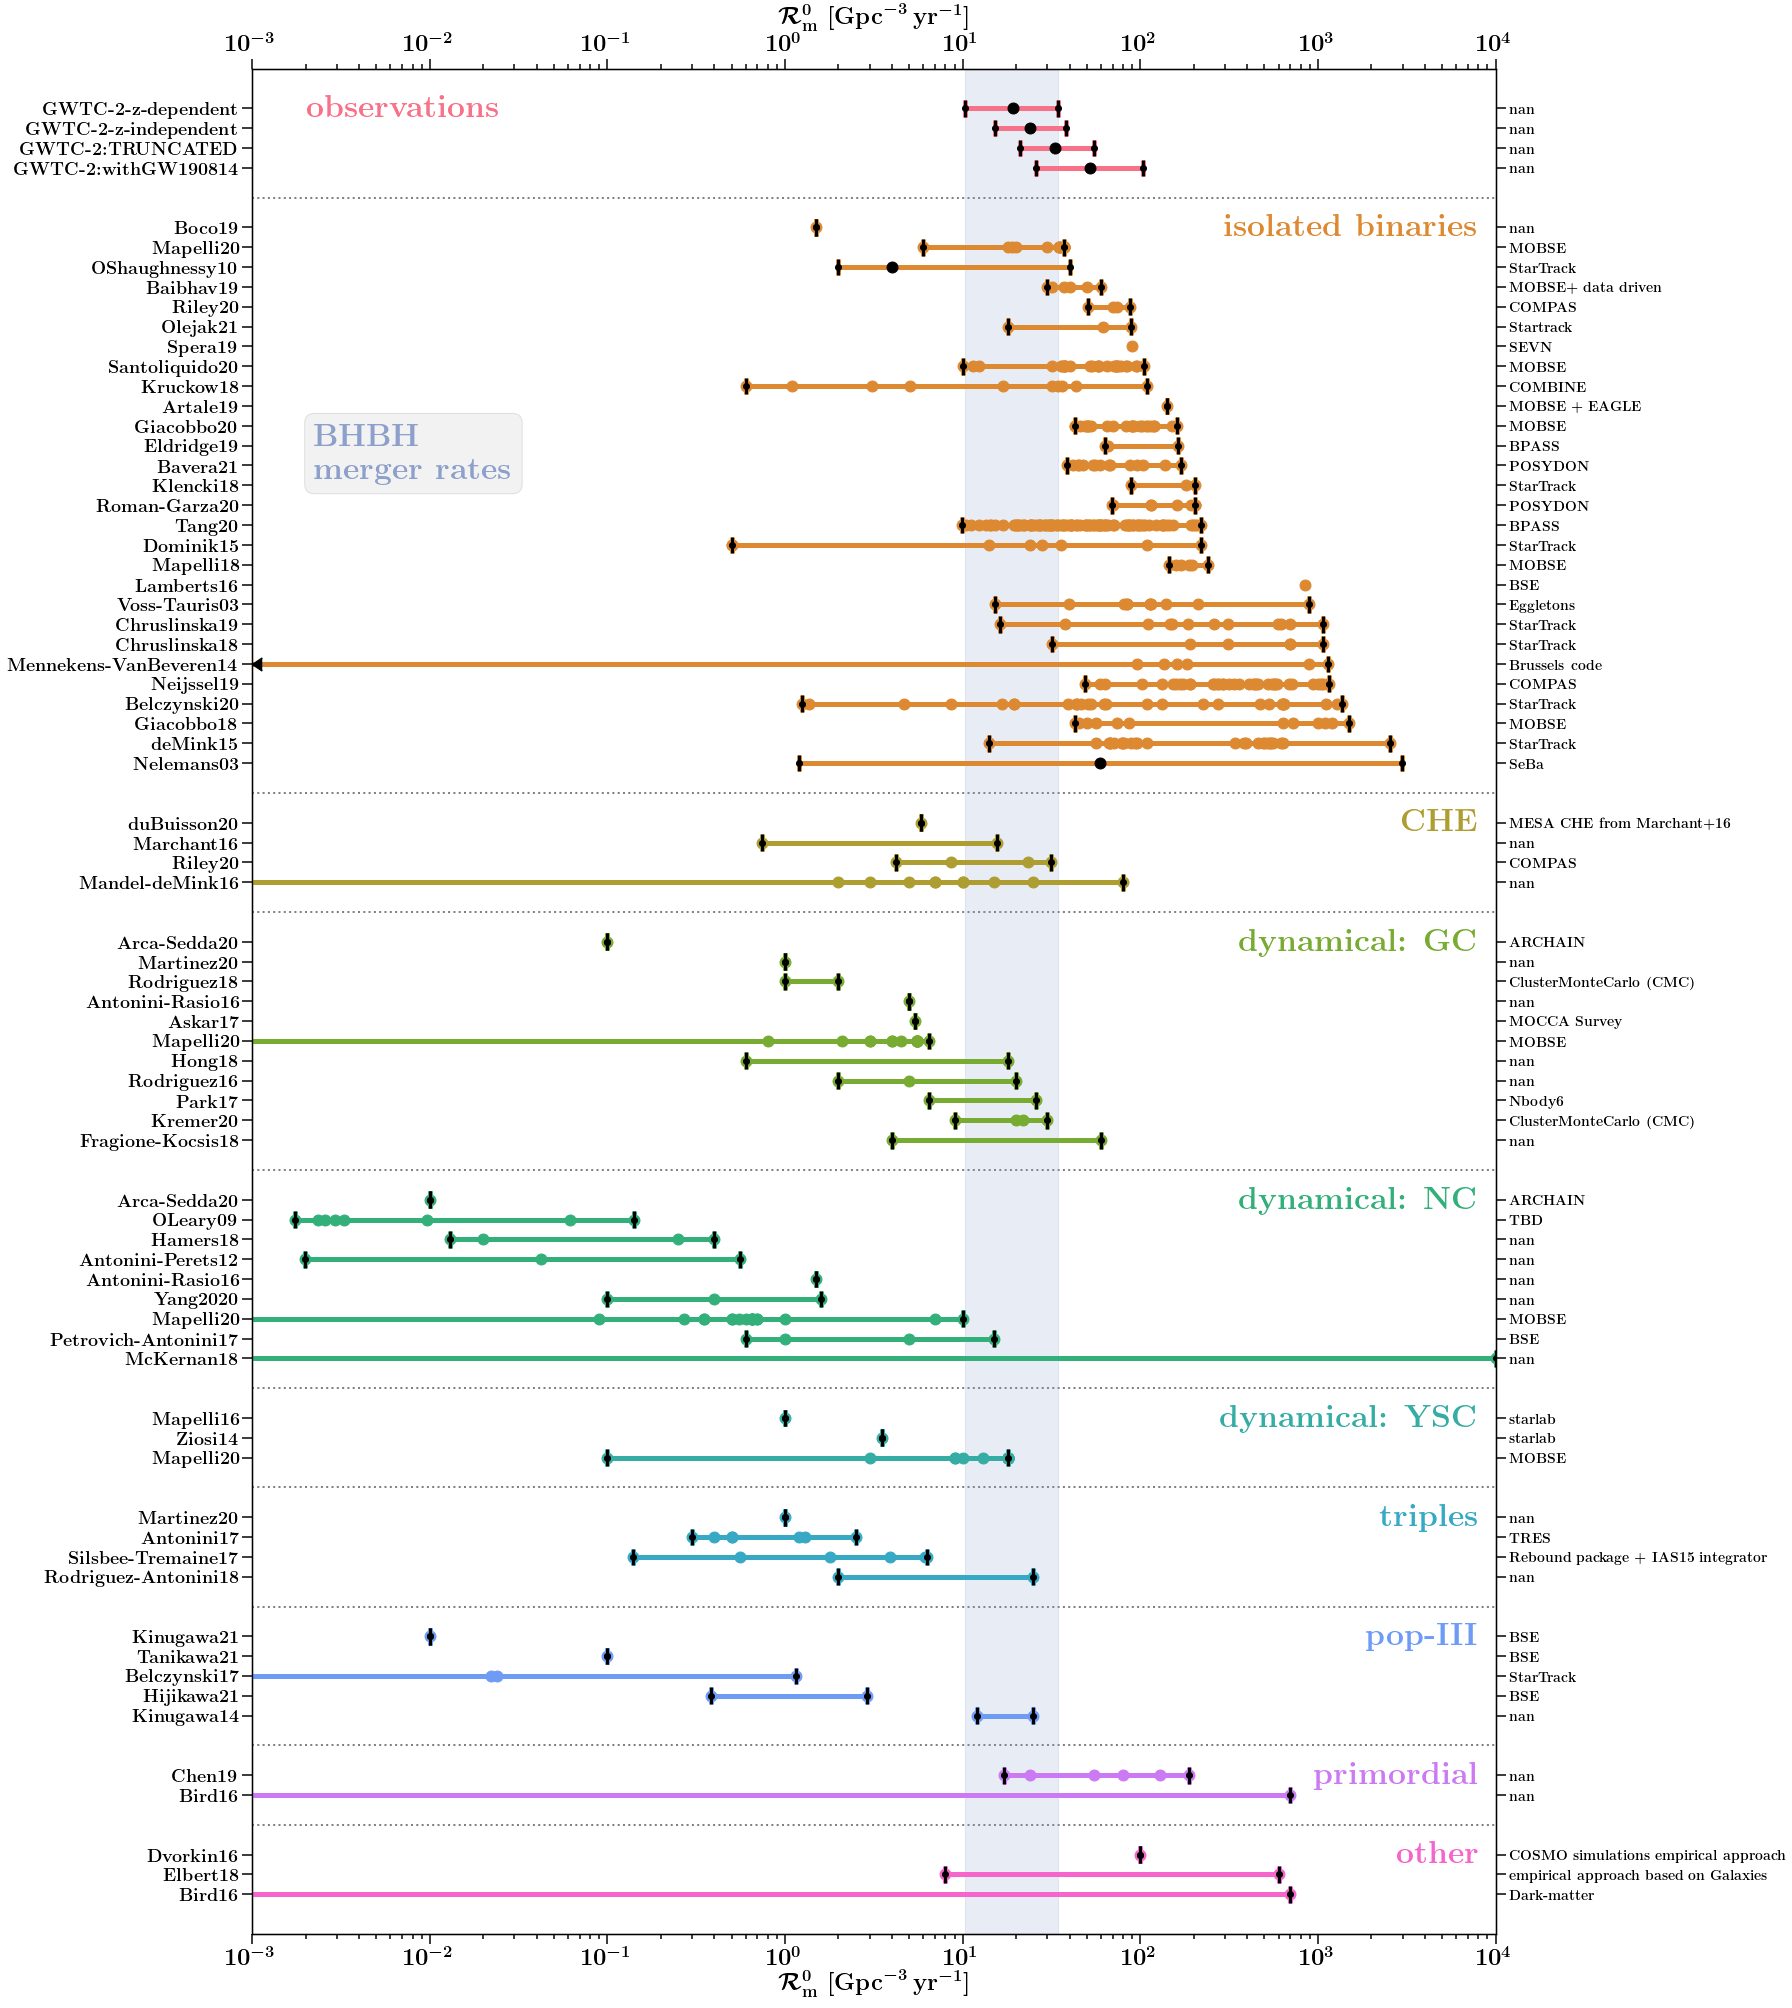

In [204]:
make_figure(DCOtype='BHBH', ordered='max')

../Data/BHNS_intrinsic_observations.csv
../Data/BHNS_intrinsic_isolated-binary-evolution.csv
../Data/BHNS_intrinsic_CHE.csv
../Data/BHNS_intrinsic_globular-clusters.csv
../Data/BHNS_intrinsic_nuclear-clusters.csv
../Data/BHNS_intrinsic_young-stellar-clusters.csv
../Data/BHNS_intrinsic_triples.csv
../Data/BHNS_intrinsic_population-III.csv


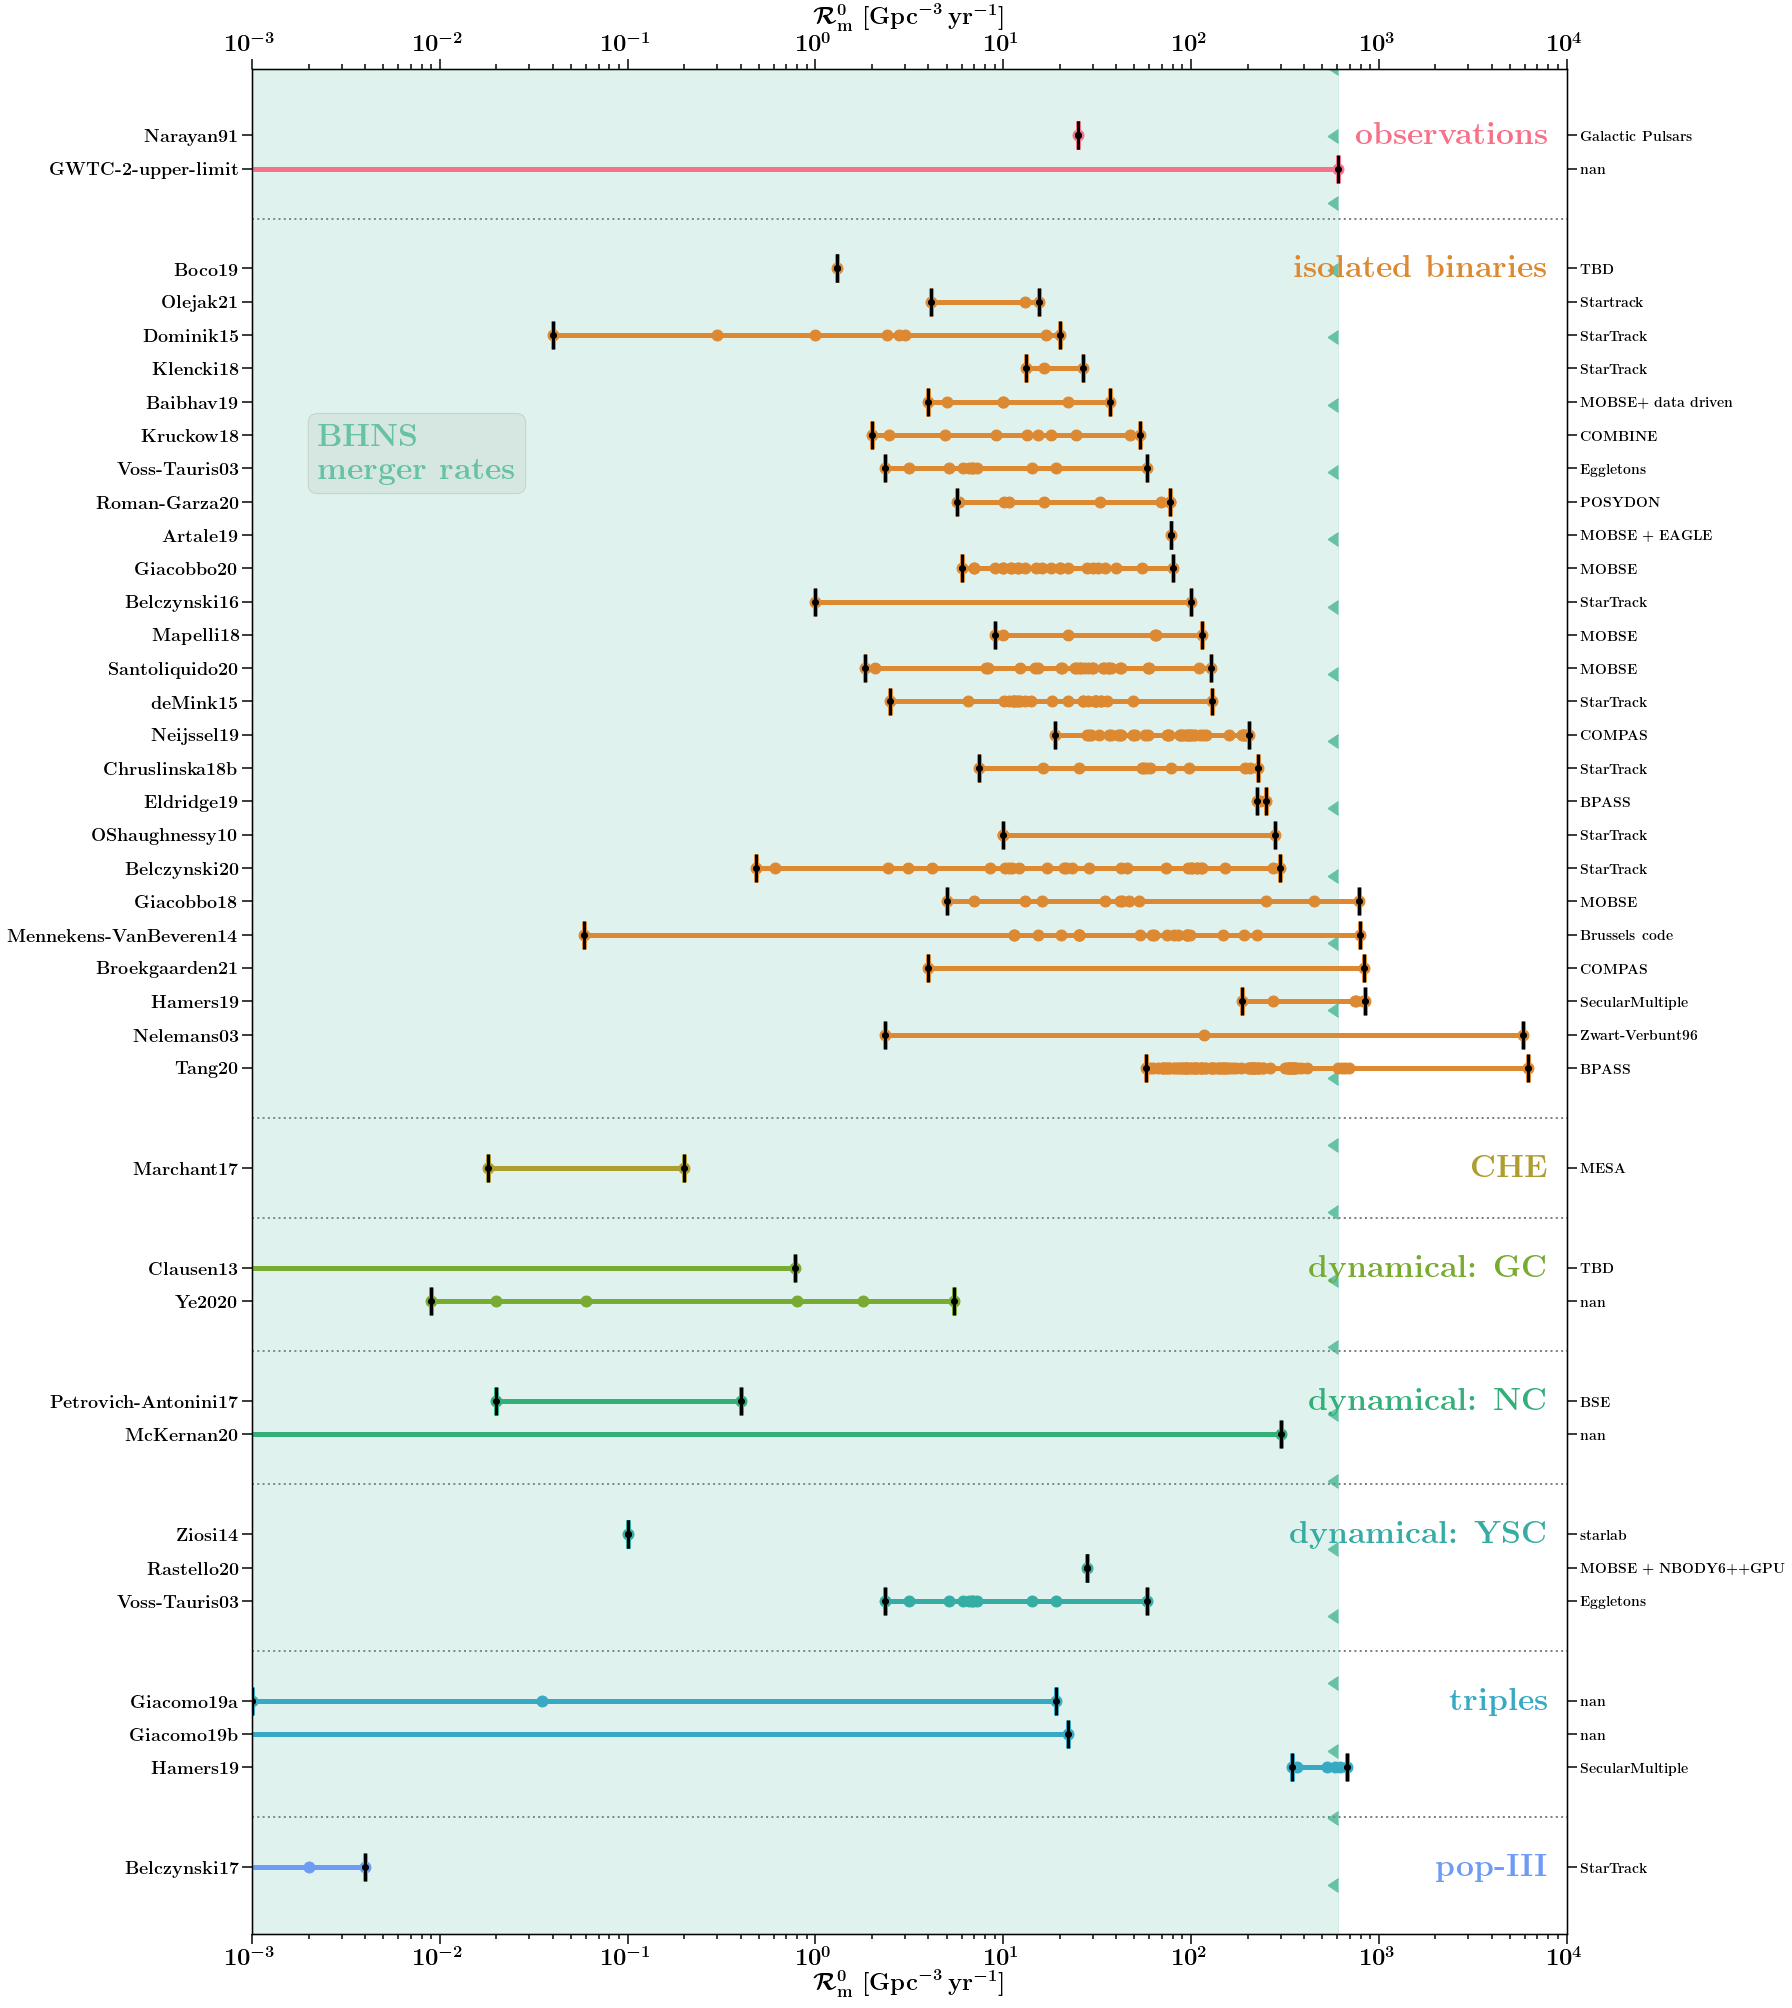

In [205]:
make_figure(DCOtype='BHNS', ordered='max')

../Data/NSNS_intrinsic_observations.csv
../Data/NSNS_intrinsic_isolated-binary-evolution.csv
../Data/NSNS_intrinsic_globular-clusters.csv
../Data/NSNS_intrinsic_nuclear-clusters.csv
../Data/NSNS_intrinsic_young-stellar-clusters.csv
../Data/NSNS_intrinsic_triples.csv
../Data/NSNS_intrinsic_population-III.csv


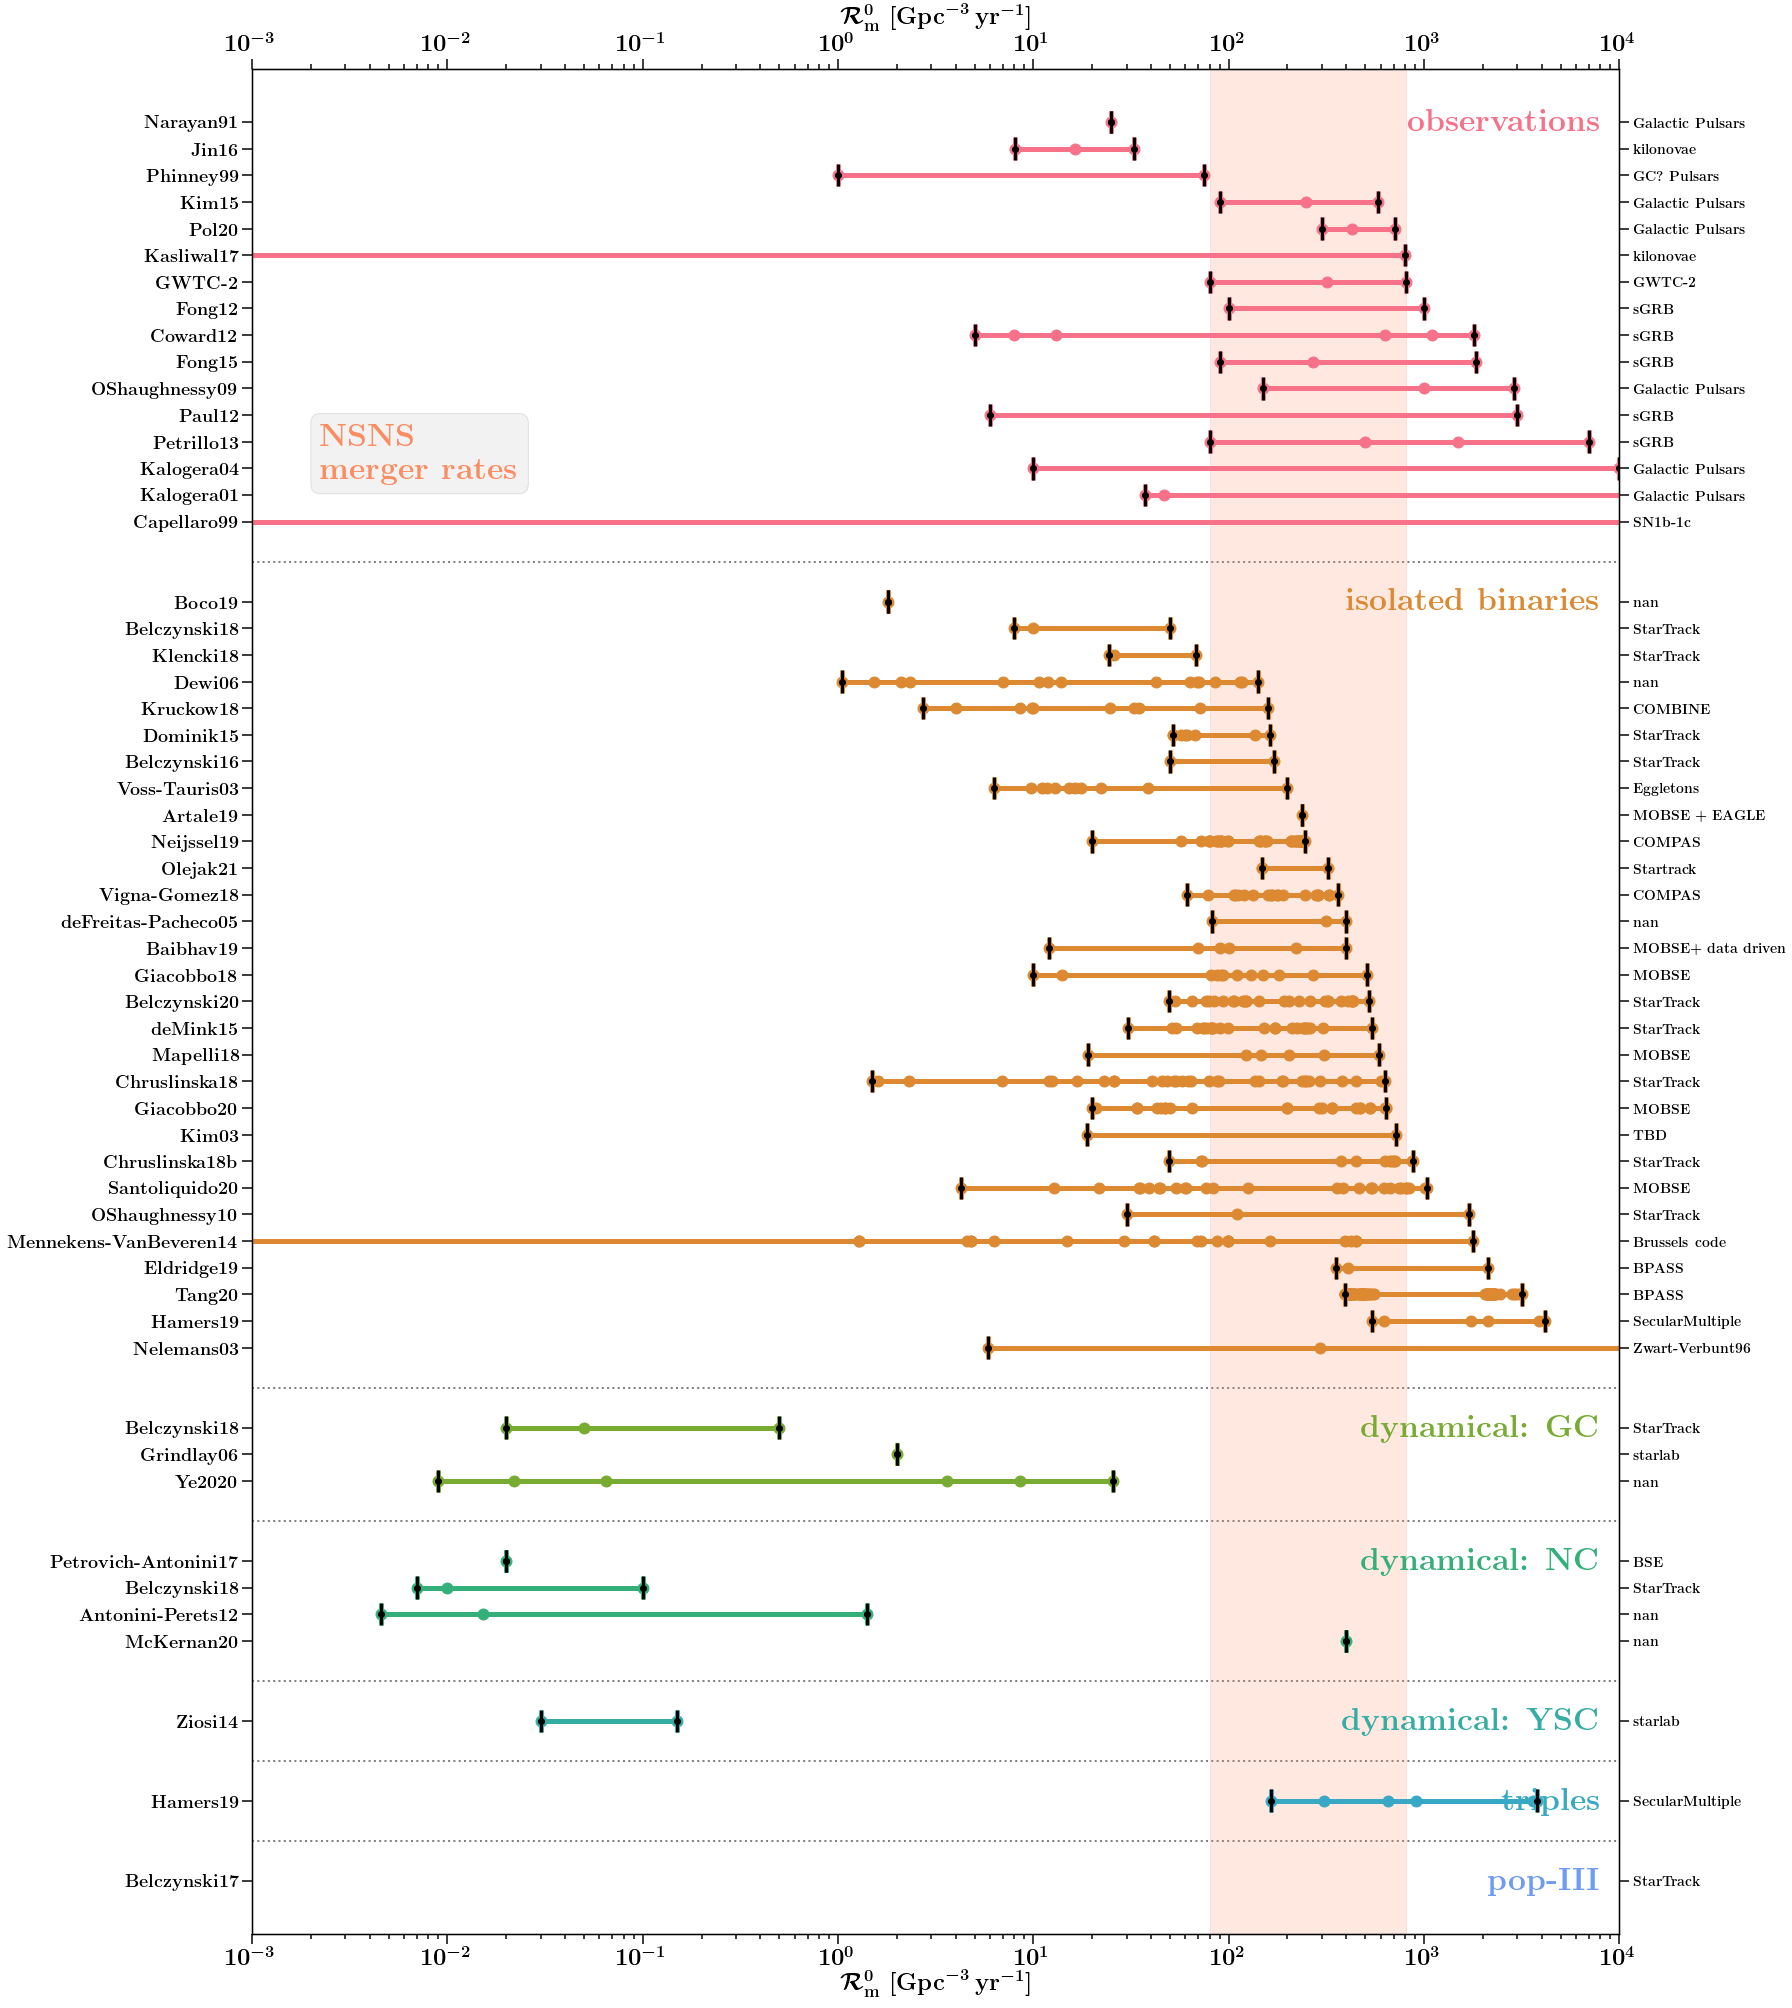

In [206]:
make_figure(DCOtype='NSNS')

# Make zoom in of single panel 

In [27]:

all_names = ['observations', 'isolated binaries', 'CHE', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC', 'triples', 'pop-III', 'primordial', 'other']
colors = sns.color_palette("husl", len(all_names))   
name_colors = dict(zip(all_names, colors))






def plotDCOrates(axe, df_names, df_colordict, df_labels, DCOtype='BHNS', ordered=None):
    

    
    ############## 2nd panel on the right ##########################
    ################################################################
    
    

    v_height=0
    for ind_file, csv_filename in enumerate(df_names):
        print(csv_filename)
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])
        df = df.iloc[:,1::2]
        
        # plotting style 
        df_ps = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,10,11,12,13])
        df_ps = df_ps.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        
        labelname = df_labels[ind_file]
        
        rate_max_list = []
        plot_styles   = []
        
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list = df.columns[sorted_ind]
            
            
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
        
        
#             colum_list_sorted = df.columns[sorted_ind]
#             codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
            
            colum_list = df.columns[sorted_ind]
        elif ordered=='year':
            colum_list = df.columns
            
        else:
            colum_list = df.columns
            
            
        # obtain ordered:
        
        
        v_height+= -1
        for ind_n, name in enumerate(colum_list):
            
            
            
            rate = df[name]
            mask_notna = (df[name].notna())
            rate = rate[mask_notna]

            # read in plotting style 
            ps = df_ps[name][0]
            if ps in range(20):
                plot_using_plotting_style(axe, ps, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
            else: 
                plot_using_plotting_style(axe, ps=3, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
#                 axe.scatter(rate,  v_height*np.ones_like(rate), s=105, c='gray', zorder=1)
#                 axe.errorbar(x=[np.min(rate),np.max(rate)], y=2*[v_height], yerr=2*[0.3], color=df_colordict[labelname], zorder=5, lw=5)


            # if plotting the first rate, add in text which type of formation channel we are plotting 
#             if ind_n==(0): #len(df.columns)-1
#                 if (DCOtype=='BHBH') & (ind_file==0):
#                     axe.text(2*1E-3, v_height, s=r'\textbf{%s}'%df_labels[ind_file] , rotation = 0, fontsize = fs+8, color=df_colordict[labelname], ha = 'left', va='center', weight = 'bold')
                
#                 else:
#                     axe.text(8*1E3, v_height, s=r'\textbf{%s}'%df_labels[ind_file] , rotation = 0, fontsize = fs+8, color=df_colordict[labelname], ha = 'right', va='center', weight = 'bold')
                
            v_height+= -1  # height of rate to plot on vertical axes  

            
        v_height+= -1
        if ind_file!=(len(df_names)-1):       
            axe.plot([1E-3, 1E4],  [v_height+0.5]*2, lw=2, c='gray', ls=':', zorder=1)
    
    
    return 



def make_figure_single(DCOtype='BHNS', ordered='max', label='observations'):
    
    
    ncols, nrows=1,1
    if label =='observations':
        names =   ['../Data/'+DCOtype+'_intrinsic_observations.csv']
    rate_labels = [label]
        
        
    f_len = 8
    if DCOtype=='BHNS':
        f_len = 4 
    elif DCOtype=='NSNS':
        f_len = 12
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(25,f_len), gridspec_kw={"width_ratios":[1], "height_ratios":[1]})     
    
    
    text_DCO = r'\textbf{%s}'%DCOtype + '\n' + r'\textbf{merger rates}'
    textbox_props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
    
    
    
    axe.text(0.05, 0.81, s=text_DCO, rotation = 0, fontsize = fs+8, color =DCOtypeColorsDict[DCOtype], ha = 'left', va='top',\
             transform=axe.transAxes, weight = 'bold', bbox=textbox_props)   
        
        
    plotDCOrates(axe=axe, df_names=names, df_colordict=name_colors, df_labels=rate_labels, DCOtype=DCOtype, ordered=ordered)
    make_up_axes(axe, DCOtype, df_names=names,ordered=ordered)
    
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + '_zoom.png', dpi=300, transparent=False)#,\
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + '_zoom.pdf')
    plt.show()

    plt.close()    
    
    
    



../Data/BHBH_intrinsic_observations.csv
1.0


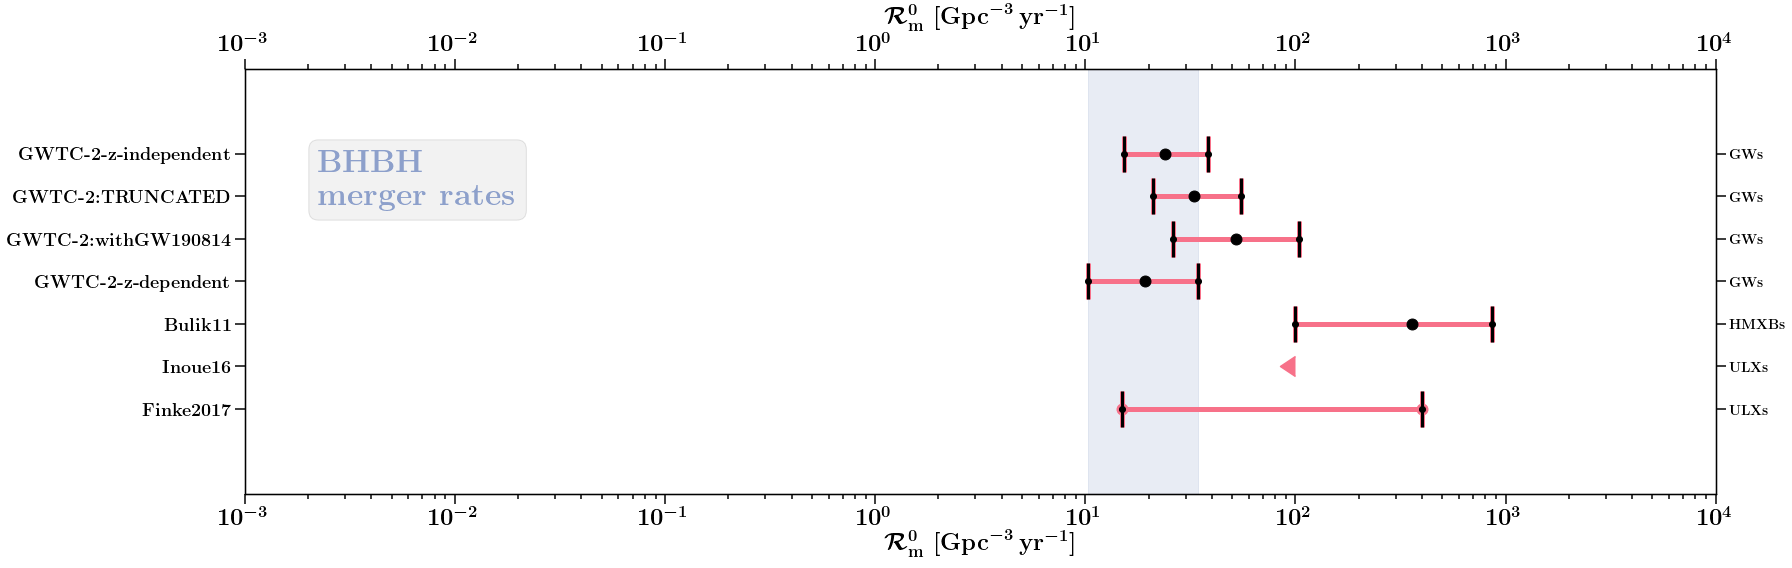

In [24]:
make_figure_single(DCOtype='BHBH', ordered='code', label='observations')

../Data/NSNS_intrinsic_observations.csv


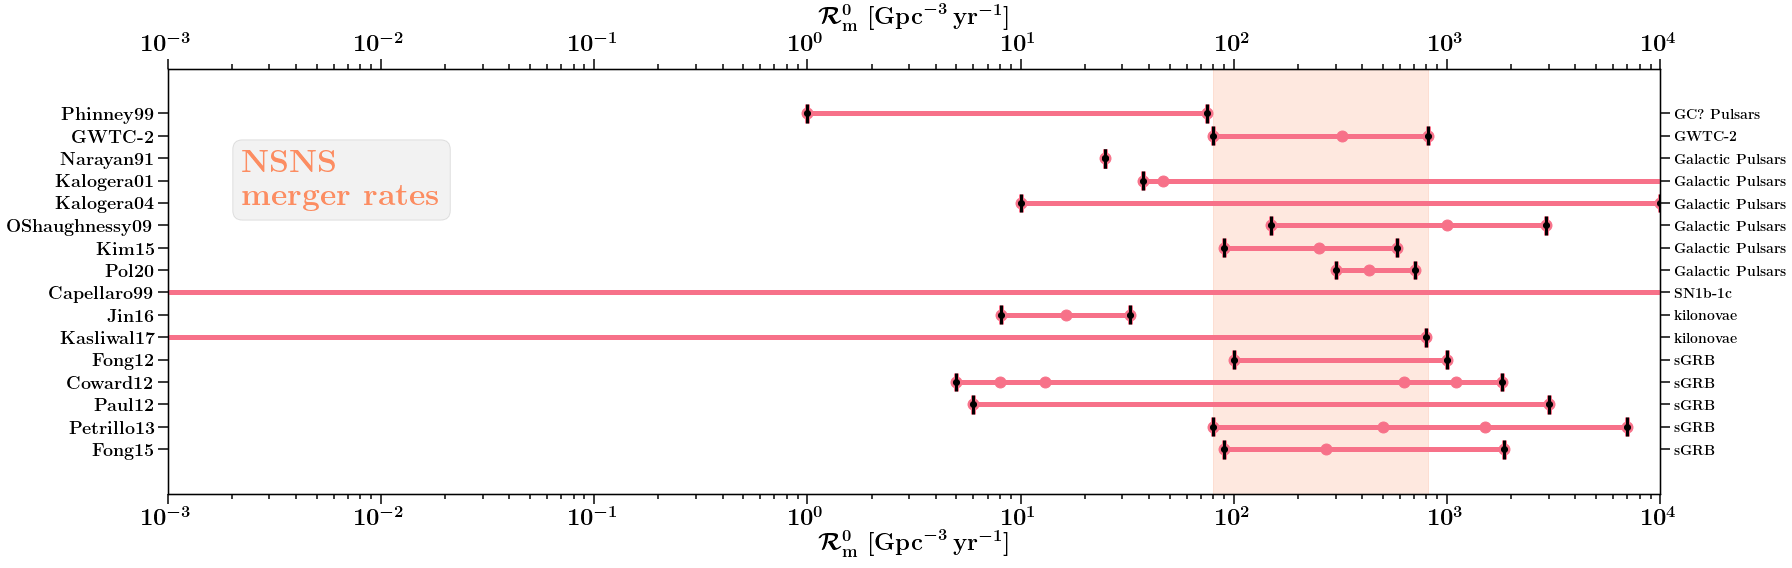

In [12]:
make_figure_single(DCOtype='NSNS', ordered='code', label='observations')

../Data/BHNS_intrinsic_observations.csv
1


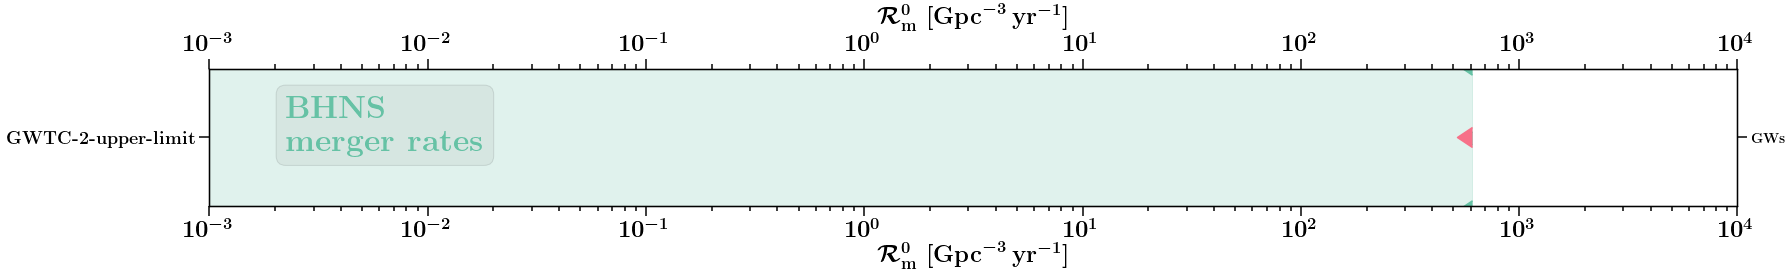

In [28]:
make_figure_single(DCOtype='BHNS', ordered='code', label='observations')